<h1> Climbing Ability Regression Model</h1>

The purpose of this project is to compare and contrast various popular regression methods - DecisionTreeClassifier, AdaBoost, RandomForestClassifier and XGBoost. I will also be seeing how various processing techniques affect the performance of the models, such as methodologies to deal with NULL values, hyper parameter selection, sandbagging techniques etc. The goal is not to produce the most perfectly fine tuned model (or close to), but to test a range of methodologies used to create regression models and to develop some deeper understanding of their applied nuances. In addition, creating a code repository for different stages of this investigation (visualising decision trees, comparing different models, cross validation, hyper parameter tuning) will be valuable for future projects.

The dataset itself is found from Kaggle (https://www.kaggle.com/dcohen21/8anu-climbing-logbook). 

<h3> Key Outcomes and Learnings </h3>

<ul>
<li> How to fit a simple decision tree, create a visualisation of it and draw top-line conclusions.</li>
<li> Found a simple way to compare baseline models.</li>
<li> Found out-of-the-box AdaBoost exemplified some of it's inherent flaws in smaller datasets, possibly overfitting to noise (especially noticeable in (high K) KFold cross validation on the smaller dataset).</li>
<li> Dealing with NULL values on a larger dataset as opposed to a smaller, complete dataset decreased almost all of our model's variance by a considerable amount. </li>
<li> ROC curves become exponentially more complicated to plot with in multi-class regression problems, making accuracy score the most easily attainable measure of model performance. During CV, using roc_auc as a performance metric was not possible. </li>
<li> Precision/recall measurements in multi-class problems denote a single precision/recall per class predicted. The methodology remains the same to calculate precision (number of correctly predicted beginners out of all predicted beginners) and recall (of all actual beginners, how many predicted correctly).</li>
<li> Wrote simple methodology to tune hyper-parameters using RandomizedGridSearchCV.</li>
<li> Applied hash functions, created dummy variables and gained experience using a number of different data manipulation techniques in Python </li>
    
</ul>

<h3> Contents </h3>
<ul>
<li>Data Cleaning and Decision Tree Visualisation  </li>
<li>Regression Model Selection </li>
<li>Testing NULL Management Methodologies </li>
<li>Hyper-Parameter Tuning and Insights </li>

</ul>


<h2> Data Cleaning and Decision Tree Visualisation </h2>

This project's aim is to predict climber's skill level (arbitrary skill levels from https://sportrock.com/understanding-climbing-grades/) and hardest climb achieved.
All previous data processing and cleaning was done in python, and reached memory error when replicating on entire dataset.
Instead repeated with all manipulation done in SQLite DB browser using the following script, and created .csv's of 1) a table that only selects rows with non-NULL or blank feature variables, and another with the complete dataset including the NULLs to test the effect of NULL-handling methodologies.

In [1]:
# #sql cleaning script 
# creating two tables, one which only selects rows with non null/blank feature variables and the other with the 
# complete dataaset with nulls

# DROP TABLE IF EXISTS climbing_data_cleaning_1;
# CREATE TABLE climbing_data_cleaning_1 AS 
# SELECT   t1.id as ascent_id
# 		,t1.user_id
# 		,t1.rating
# 		,climb_try
# 		,UPPER(t3.country) as country
# 		,CAST(t3.sex as height) as sex
# 		,CAST(t3.weight as int ) as weight
# 		,CAST(t3.height as int) as height
# 		,2020 - t3.started as years_climbing
# 		,UPPER(t3.occupation) as occupation
# 		,CASE WHEN sponsor1 > '' OR sponsor2 > '' OR sponsor3 > '' then 1 else 0 end as sponsored
# 		,count(*) OVER(PARTITION BY user_id) AS number_of_logged_climbs
# 		,t2.fra_boulders as grade
# 		,t2.score as grade_number
# 		,MAX(t2.score) OVER(PARTITION BY user_id) AS max_grade_achieved 
# 		,t4.shorthand
# 		,CASE WHEN t2.id IS NULL then 1 else 0 end as failed_grade_join 
# 		,CASE WHEN t3.id IS NULL then 1 else 0 end as failed_user_join
# 		,CASE WHEN t4.id IS NULL then 1 else 0 end as failed_method_join 
# FROM ascent t1 
# LEFT JOIN grade t2 
# ON t1.grade_id = t2.id
# LEFT JOIN user t3
# ON t1.user_id = t3.id
# LEFT JOIN method t4
# ON t1.method_id = t4.id
# WHERE t4.shorthand != 'toprope';

# DROP TABLE IF EXISTS climbing_data_cleaning_final_removed_nulls;
# CREATE TABLE climbing_data_cleaning_final_removed_nulls AS 
# SELECT   DISTINCT  user_id
# 		 ,country
# 		 ,sex
# 		 ,weight
# 		 ,height
# 		 ,years_climbing
# 		 ,occupation
# 		 ,sponsored
# 		 ,number_of_logged_climbs
# 		 ,max_grade_achieved AS max_climbing_grade
# 		 ,CASE WHEN max_grade_achieved BETWEEN 0 AND 450 THEN CAST(1 AS int)
# 			   WHEN max_grade_achieved BETWEEN 451 AND 750 THEN  CAST(2 AS int)
# 			   WHEN max_grade_achieved BETWEEN 751 AND 950 THEN CAST(3 AS int)
# 			   WHEN max_grade_achieved > 951 THEN CAST(4 AS int) END AS skill_level
# FROM climbing_data_cleaning_1
# WHERE occupation > '' 
# AND height > 0
# AND weight > 0;

# DROP TABLE IF EXISTS climbing_data_cleaning_final_with_nulls;
# CREATE TABLE climbing_data_cleaning_final_with_nulls AS 
# SELECT   DISTINCT  user_id
# 		 ,country
# 		 ,sex
# 		 ,weight
# 		 ,height
# 		 ,years_climbing
# 		 ,occupation
# 		 ,sponsored
# 		 ,number_of_logged_climbs
# 		 ,max_grade_achieved AS max_climbing_grade
# 		 ,CASE WHEN max_grade_achieved BETWEEN 0 AND 450 THEN CAST(1 AS int)
# 			   WHEN max_grade_achieved BETWEEN 451 AND 750 THEN  CAST(2 AS int)
# 			   WHEN max_grade_achieved BETWEEN 751 AND 950 THEN CAST(3 AS int)
# 			   WHEN max_grade_achieved > 951 THEN CAST(4 AS int) END AS skill_level
# FROM climbing_data_cleaning_1;


In [2]:
#Import Libraries 
import pandas as pd
import sqlite3
import numpy as np
from IPython.display import Image  
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO  

from graphviz import Source
from IPython.display import display
from IPython.display import SVG
from xgboost import XGBClassifier
from tqdm import tqdm

print("Imported all libraries successfully")

Imported all libraries successfully


C:\Users\Michael\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [3]:
#import dataset with no nulls first 

#using read_csv
df_clean = pd.read_csv("cleaned_table_removed_nulls.csv")

#using sqlite (unsure how to add relative path connection to sql lite)
# con = sqlite3.connect("climbing_predictive_model_database.db")

# df_clean = pd.read_sql_query("SELECT * from cleaned_data_complete", con)

print("Data imported correctly")

Data imported correctly


In [4]:
#Project changed to predicting skill level instead of specific max grade. dropping max_climbing_grade and inspecting head
df_clean = df_clean.drop('max_climbing_grade', 1)
df_clean.head()
df_clean.info()

,user_id,country,sex,weight,height,years_climbing,occupation,sponsored,number_of_logged_climbs,skill_level
0,11,SWE,0,73,175,22,STUDENT,0,278,4
1,16,NOR,0,68,177,24,TEACHER,0,171,4
2,19,BEL,0,68,180,24,STUDENT,1,63,2
3,34,NZL,0,68,180,27,SYSTEMS MANAGER,0,31,3
4,38,GBR,0,73,178,27,CLIMBING WALL GUY,0,1179,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7294 entries, 0 to 7293
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   user_id                  7294 non-null   int64 
 1   country                  7293 non-null   object
 2   sex                      7294 non-null   int64 
 3   weight                   7294 non-null   int64 
 4   height                   7294 non-null   int64 
 5   years_climbing           7294 non-null   int64 
 6   occupation               7291 non-null   object
 7   sponsored                7294 non-null   int64 
 8   number_of_logged_climbs  7294 non-null   int64 
 9   skill_level              7294 non-null   int64 
dtypes: int64(8), object(2)
memory usage: 570.0+ KB


In [5]:
#creating dummy variables for categorical columns and adding to dataframe
df_dummy_country = pd.get_dummies(df_clean['country'])
df_dummy_occupation = pd.get_dummies(df_clean['occupation'])

df_clean_final = pd.concat([df_clean,  df_dummy_occupation], axis=1)
df_clean_final = df_clean_final.merge(df_dummy_occupation,left_index=True, right_index=True)

df_clean_final = pd.concat([df_clean,  df_dummy_country], axis=1)
df_clean_final = df_clean_final.merge(df_dummy_country,left_index=True, right_index=True)

df_clean_final.head()
df_clean_final.info()
print("Dummy variables created/appended, index reset")

,user_id,country,sex,weight,height,years_climbing,occupation,sponsored,number_of_logged_climbs,skill_level,...,UKR_y,USA_y,VEN_y,VGB_y,VNM_y,WLF_y,WSM_y,YUG_y,ZAF_y,ZWE_y
0,11,SWE,0,73,175,22,STUDENT,0,278,4,...,0,0,0,0,0,0,0,0,0,0
1,16,NOR,0,68,177,24,TEACHER,0,171,4,...,0,0,0,0,0,0,0,0,0,0
2,19,BEL,0,68,180,24,STUDENT,1,63,2,...,0,0,0,0,0,0,0,0,0,0
3,34,NZL,0,68,180,27,SYSTEMS MANAGER,0,31,3,...,0,0,0,0,0,0,0,0,0,0
4,38,GBR,0,73,178,27,CLIMBING WALL GUY,0,1179,4,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7294 entries, 0 to 7293
Columns: 208 entries, user_id to ZWE_y
dtypes: int64(8), object(2), uint8(198)
memory usage: 1.9+ MB
Dummy variables created/appended, index reset


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

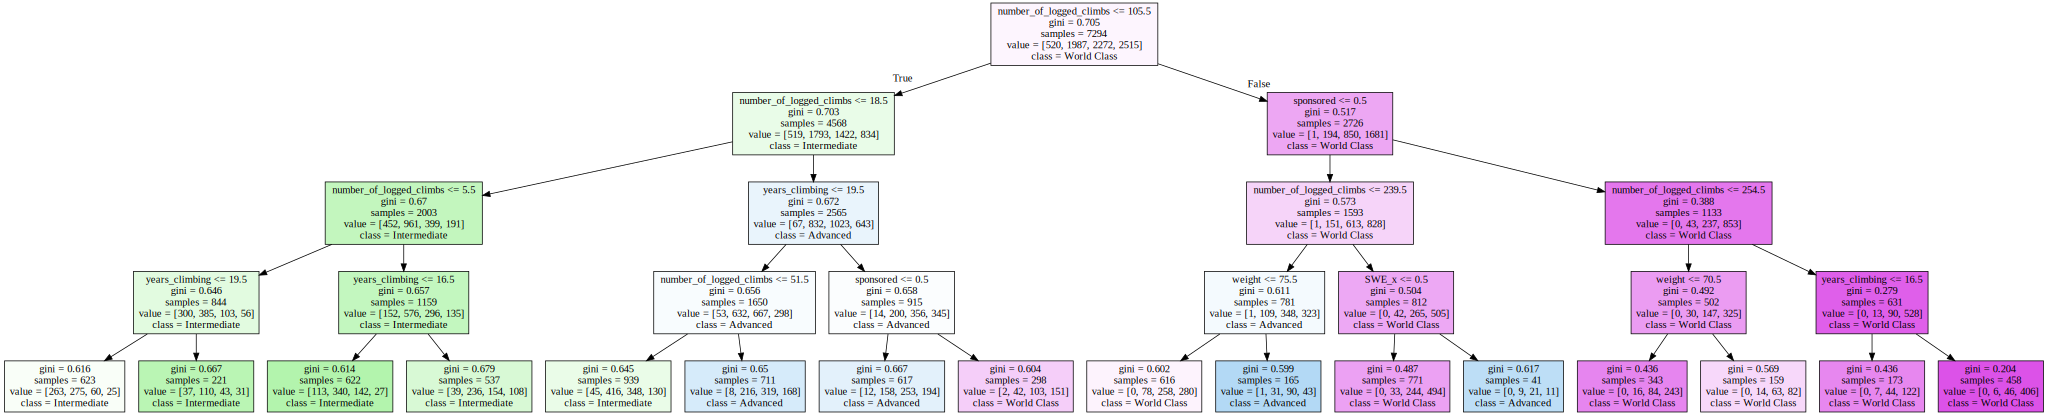

In [6]:
#visualizing the decision tree before any data manipulation 
clf = DecisionTreeClassifier(max_depth = 4, random_state=42)

#dropping categorical variables that we replaced with dummy variables 
df_clean_X = df_clean_final.loc[:, df_clean_final.columns.drop(['skill_level', 'country', 'occupation'])]
#create target variable df 
df_clean_y = df_clean_final['skill_level']

clf.fit(df_clean_X, df_clean_y)

graph = Source(tree.export_graphviz(clf
                                    ,out_file=None
                                    ,filled = True
                                    ,feature_names = df_clean_X.columns
                                    ,class_names = ['Beginner', 'Intermediate', 'Advanced', 'World Class']))
display(SVG(graph.pipe(format='svg')))


Interesting and somewhat expected results. Speaking very generally over the decision tree, sponsored climbers, climbers with more logged climbs, longer time climbing and low(er) weight tended to climb higher grades. The number of years separator seemed to be much larger than anticipated, it seems younger climbers do not tend to log their climbs as much as older climbers. Another interesting find is that of climbers with many logged climbs who are not sponsored, those who were from Sweden tended to be classified as higher skilled, possibly speaking to their widespread climbing community and high standard of recreational climbers.

Speaking more generally over the classifier, having a multi-class regression such as this with 4 target variables lead to relatively high Gini scores. An interesting investigation would be to repeat this project  with a binary classifier (beginner climber/good climber) to see if we can retrieve lower Gini scores.


<h2> Regression Model Selection </h2>

In [7]:
#finding the optimal model - data cleaning 1 (optional if we don't want to scale numerical columns)

#scaling the columns
#set scaler
scaler = StandardScaler()

#find numerical columns
numeric_columns = df_clean.select_dtypes(include=np.number).columns.tolist()
numeric_columns.remove('skill_level')

df_clean[numeric_columns] = scaler.fit_transform(df_clean[numeric_columns])
print("Scaled columns sucessfully")

Scaled columns sucessfully


In [8]:
#finding the optimal model - data cleaning 2
#setting all categorical variables as numerical 
df_clean['occupation'] = df_clean['occupation'].apply(lambda x: hash(x))
df_clean['country'] = df_clean['country'].apply(lambda x: hash(x))

print("Hash function applied successfully")

Hash function applied successfully


In [9]:
#creating training and test datasets
df_decision_tree_X = df_clean.loc[:, df_clean.columns.drop(['skill_level'])]
df_decision_tree_y = df_clean['skill_level']

X_train, X_test, y_train, y_test = train_test_split(df_decision_tree_X, df_decision_tree_y, test_size=0.5, random_state=42)

print("Training and test datasets split correctly ")

Training and test datasets split correctly 


Since this is a mutliclass regression problem, we will be testing these model's accuracy score in lieu of roc_auc.

In [10]:
#define base models to test '
models = [
    DecisionTreeClassifier(random_state = 1),
    XGBClassifier(random_state = 2
                #param={'max_depth':3, 'eta':1, 'objective':'binary:logistic' }
                 ),
    AdaBoostClassifier(random_state = 3),
    LogisticRegression(random_state = 4),
    RandomForestClassifier(random_state = 5),
]

print("Models defined correctly")

CV = KFold(n_splits=10)
model_scores = []
for model in tqdm(models):
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, df_decision_tree_X, df_decision_tree_y
                                 , scoring='accuracy', cv=CV)
    for iteration, accuracy in enumerate(accuracies):
        model_scores.append((model_name, iteration, accuracy))

print("Models ran correctly")

  0%|                                                    | 0/5 [00:00<?, ?it/s]

Models defined correctly


100%|████████████████████████████████████████████| 5/5 [00:42<00:00,  8.42s/it]

Models ran correctly


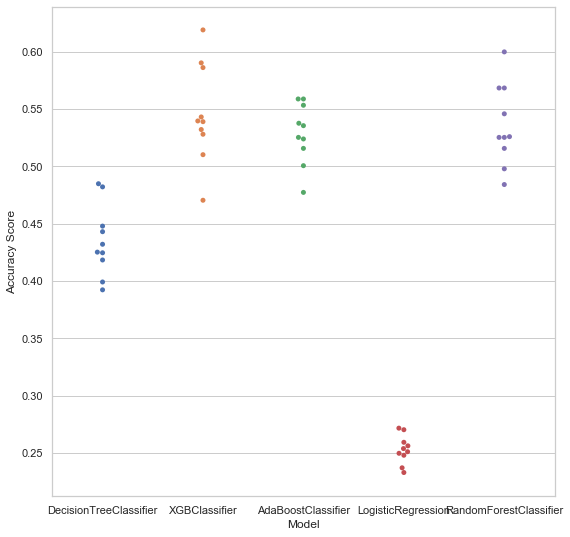

In [11]:
#creating visualisation of all models to compare the accuracy score of each cross validation iteration 
sns.set(style="whitegrid")
model_scores_df = pd.DataFrame(model_scores, columns =['Model', 'Iteration', 'Accuracy Score'])

fig, ax  = plt.subplots(figsize = (9,9))
sns.swarmplot(data=model_scores_df, x='Model', y='Accuracy Score')

Interesting results. AdaBoost, XGBoost and RandomForestClassifier all produce the most accurate models. All of the models exhibit high variance, indicating low bias and possible under fitting. Due to the small amount of features of the dataset, this is somewhat expected and we will try and reduce the variance for more consistent model performance. 

Recapping our findings so far:

We have joined all datasets together in SQL to produce our final table and have removed any rows with null values. We have visualised the variables and found which features/thresholds are the best predictors for climber's skill levels in our dataset. Finally, we have found that our best out-of-the-box model is AdaBoostClassifier/XGBoost/RandomForestClassifier with no hyper-parameter tuning.

We will now repeat the process using the entire dataset to test different methodologies of dealing with missing/null values.


<h2> Testing NULL Management Methodologies </h2>

In [12]:
#import dataset with nulls  

#using sqlite (unsure how to add relative path connection to sql lite)
# con = sqlite3.connect(r"climbing_predictive_model_database.sqlite")

# df_clean = pd.read_sql_query("SELECT * from cleaned_data_complete", con)

#using read csv
df_clean = pd.read_csv("cleaned_table_complete.csv")

print("Data imported correctly")

Data imported correctly


In [13]:
#Project changed to predicting skill level instead of specific max grade. dropping max_climbing_grade and inspecting head
df_clean = df_clean.drop('max_climbing_grade', 1)
df_clean.head()
df_clean.info()

#roughly 5x the amount of data as the dataset with no null values in any of the features
#Hopefully this will lead to more accurate models or lower variance models

,user_id,country,sex,weight,height,years_climbing,occupation,sponsored,number_of_logged_climbs,skill_level
0,1,SWE,0.0,73.0,177.0,24.0,NaN,0,209,4
1,2,SWE,0.0,0.0,0.0,20.0,NaN,0,7,2
2,3,SWE,0.0,78.0,180.0,25.0,NaN,0,61,4
3,4,SWE,1.0,58.0,165.0,19.0,NaN,0,179,4
4,5,USA,0.0,0.0,0.0,29.0,NaN,0,389,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35656 entries, 0 to 35655
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  35656 non-null  int64  
 1   country                  35613 non-null  object 
 2   sex                      35653 non-null  float64
 3   weight                   35653 non-null  float64
 4   height                   35653 non-null  float64
 5   years_climbing           35653 non-null  float64
 6   occupation               9245 non-null   object 
 7   sponsored                35656 non-null  int64  
 8   number_of_logged_climbs  35656 non-null  int64  
 9   skill_level              35656 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 2.7+ MB


In [14]:
#inspecting weight feature
print("Weight distribution before replacing values")
df_clean['weight'].value_counts(ascending=False, normalize=True)
#35% of our weights are 0 value 

#set 0 values as NAN and replace
df_clean['weight'].replace(0, np.nan, inplace= True)
mean_weight=df_clean['weight'].mean()
df_clean['weight']=df_clean['weight'].fillna(mean_weight)

print("Weight distribution after replacing values")
df_clean['weight'].value_counts(ascending=False, normalize=True)

Weight distribution before replacing values


0.0      0.372199
68.0     0.133285
73.0     0.128629
63.0     0.110061
78.0     0.070906
58.0     0.055087
53.0     0.036883
83.0     0.036855
48.0     0.018764
88.0     0.012201
43.0     0.006030
40.0     0.005806
100.0    0.005750
93.0     0.005245
98.0     0.002300
Name: weight, dtype: float64

Weight distribution after replacing values


68.302864     0.372252
68.000000     0.133274
73.000000     0.128618
63.000000     0.110052
78.000000     0.070900
58.000000     0.055082
53.000000     0.036880
83.000000     0.036852
48.000000     0.018763
88.000000     0.012200
43.000000     0.006030
40.000000     0.005805
100.000000    0.005749
93.000000     0.005245
98.000000     0.002300
Name: weight, dtype: float64

In [15]:
#inspecting height feature
print("Height distribution before replacing values")
df_clean['height'].value_counts(ascending=False, normalize=True)
#36% of our weights are 0 value

#set 0 values as NAN and replace
df_clean['height'].replace(0, np.nan, inplace= True)
mean_height=df_clean['height'].mean()
df_clean['height']=df_clean['height'].fillna(mean_height)
                            
print("height distribution after replacing values")
df_clean['height'].value_counts(ascending=False, normalize=True)

Height distribution before replacing values


0.0      0.369871
180.0    0.054946
178.0    0.043615
175.0    0.041091
170.0    0.037276
           ...   
254.0    0.000028
115.0    0.000028
133.0    0.000028
20.0     0.000028
96.0     0.000028
Name: height, Length: 158, dtype: float64

height distribution after replacing values


174.545491    0.369924
180.000000    0.054942
178.000000    0.043611
175.000000    0.041087
170.000000    0.037273
                ...   
115.000000    0.000028
254.000000    0.000028
3.000000      0.000028
89.000000     0.000028
25.000000     0.000028
Name: height, Length: 158, dtype: float64

In [16]:
#inspecting years_climbing feature
df_clean['years_climbing'].value_counts(ascending=False, normalize=True).head()
#30% of values showing as 2020 (previously inserted as 0 in the data)

#set 2020 values as NAN and replace
df_clean['years_climbing'].replace(2020, np.nan, inplace= True)
mean_years_climbing=df_clean['years_climbing'].mean()
df_clean['years_climbing']=df_clean['years_climbing'].fillna(mean_years_climbing)

df_clean['years_climbing'].value_counts(ascending=False, normalize=True).head()


2020.0    0.298180
20.0      0.075898
12.0      0.046251
13.0      0.045971
11.0      0.043475
Name: years_climbing, dtype: float64

16.087243    0.298239
20.000000    0.075892
12.000000    0.046247
13.000000    0.045967
11.000000    0.043471
Name: years_climbing, dtype: float64

In [17]:
#inspecting country feature
n_rows = 5
df_clean['country'].value_counts(ascending=False, normalize=True).head(n_rows)

#blank values only count for ~1% of our rows. small enough that dropping won't lead to a significant data loss
indexNames = df_clean[ df_clean['country'].str.len() <3 ].index
df_clean.drop(indexNames, inplace=True)

#ensuring that the values were dropped, following should be null 
df_clean[df_clean['country'].str.len() <3]

#after inspecting df_clean.info(), still some NULl values that can be dropped 
df_clean = df_clean.dropna(subset=['country'])


USA    0.184876
ESP    0.111027
POL    0.063741
DEU    0.060512
ITA    0.055261
Name: country, dtype: float64

,user_id,country,sex,weight,height,years_climbing,occupation,sponsored,number_of_logged_climbs,skill_level


In [18]:
#inspecting occupation variable
df_clean['occupation'].value_counts(ascending=False, normalize=True).head()
#70% of values are null. can be good grounds to eliminate this variable completely
#especially sice low frequency of other variables . for learning purposes, will test replacing with most common value
#and will test replacing the missing values with a ML model at a later stage

#replace blanks with NAN
df_clean['occupation'].replace('', np.nan, inplace= True)

df_clean['occupation'] = df_clean['occupation'].fillna(df_clean['occupation'].value_counts().index[0])

df_clean['occupation'].value_counts(ascending=False, normalize=True).head()


STUDENT       0.250352
ESTUDIANTE    0.019258
ENGINEER      0.018825
TEACHER       0.014606
CLIMBER       0.010927
Name: occupation, dtype: float64

STUDENT       0.805425
ESTUDIANTE    0.004998
ENGINEER      0.004886
TEACHER       0.003791
CLIMBER       0.002836
Name: occupation, dtype: float64

In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35611 entries, 0 to 35655
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  35611 non-null  int64  
 1   country                  35611 non-null  object 
 2   sex                      35611 non-null  float64
 3   weight                   35611 non-null  float64
 4   height                   35611 non-null  float64
 5   years_climbing           35611 non-null  float64
 6   occupation               35611 non-null  object 
 7   sponsored                35611 non-null  int64  
 8   number_of_logged_climbs  35611 non-null  int64  
 9   skill_level              35611 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 3.0+ MB


Now we have dealt with missing values in the entire dataset, by dropping rows, replacing with mean values and replacing with most common values, we can apply the same methodology to test our models

In [20]:
#define base models to test '
df_clean['occupation'] = df_clean['occupation'].apply(lambda x: hash(x))
df_clean['country'] = df_clean['country'].apply(lambda x: hash(x))

print("Hash function applied successfully")

df_model_selection_X = df_clean.loc[:, df_clean.columns.drop(['skill_level', 'occupation'])]
df_model_selection_y = df_clean['skill_level']
print("feature/target dataframes created sucessfully")

models = [
    DecisionTreeClassifier(random_state = 1),
    XGBClassifier(
                #param={'max_depth':3, 'eta':1, 'objective':'binary:logistic' }
                 ),
    AdaBoostClassifier(random_state = 2),
    LogisticRegression(random_state = 3),
    RandomForestClassifier(random_state = 4)
]

print("Models defined correctly")

CV = k_fold = KFold(n_splits=10) 
model_scores = []
for model in tqdm(models):
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, df_model_selection_X, df_model_selection_y
                                  , scoring='accuracy', cv=CV)
    for iteration, accuracy in enumerate(accuracies):
        model_scores.append((model_name, iteration, accuracy))

print("Models ran correctly")


  0%|                                                    | 0/5 [00:00<?, ?it/s]

Hash function applied successfully
feature/target dataframes created sucessfully
Models defined correctly


100%|████████████████████████████████████████████| 5/5 [02:15<00:00, 27.02s/it]

Models ran correctly


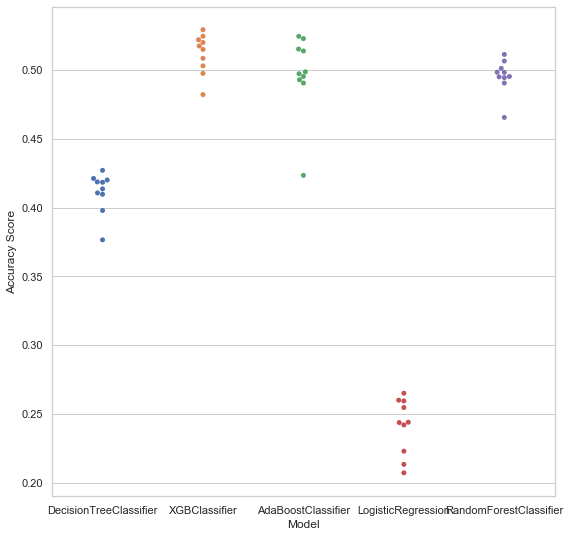

In [21]:
#creating visualisation of all models to compare the accuracy score of each cross validation iteration 
sns.set(style="whitegrid")
model_scores_df = pd.DataFrame(model_scores, columns =['Model', 'Iteration', 'Accuracy Score'])

fig, ax = plt.subplots(figsize=(9,9))
sns.swarmplot(data=model_scores_df, x='Model', y='Accuracy Score')

The methodology used to deal with the NULLs affected each model similarly, with most models reducing in accuracy scores but also decreasing in variance. Given the large variance of the first iteration and the only small decrease in variance, this is clearly an overall positive outcome. 

Further study to find the cause of the lower performance of the models will be performed, but some I assume a large portion of the findings are due to overcorrection of missing values. For a number of variables we replaced 30%+ of them with the mean of the other values. If we had a dataset with more features, likely these features would have been dropped altogether. 

A common AdaBoost criticism is that it is subject to noisy data and therefore has issues with high variance. While 10 iterations only produced one outlier, it still exemplifies this characteristic. Future projects with more suitable datasets will test to see if we can reduce AdaBoosts variance, or configure XGBoost to increase performance as this is an alleged advantage of XGBoost was that it introduces regularization parameters to reduce over fitting. 

For now as a final step to this exploratory project, we will select appropriate hyper-parameter for RandomForestClassifier (high performance with lowest variance) and calculate precision/recall.


<h2> Hyper-Parameter Tuning and Insights </h2>

In [22]:
#creating training and test datasets
df_decision_tree_X = df_clean.loc[:, df_clean.columns.drop(['skill_level'])]
df_decision_tree_y = df_clean['skill_level']

X_train, X_test, y_train, y_test = train_test_split(df_decision_tree_X, df_decision_tree_y, test_size=0.5, random_state=42)

print("Training and test datasets split correctly ")

Training and test datasets split correctly 


In [23]:
#hyperparameter tuning 
#set parameters to tune

n_estimators = [100, 120, 140, 160, 180, 200]
max_depth = [5, 6, 7, 8, 9, 10]

param_grid = {'n_estimators' : n_estimators,
              'max_depth' : max_depth } 

model = RandomForestClassifier()

print("Starting grid search ")

clf = RandomizedSearchCV(estimator = model,
                param_distributions = param_grid,
                scoring = 'accuracy',
                n_iter = 10,
                random_state = 42)

clf.fit(X_train, y_train)

#prints the best accuracy score 
print("The highest accuracy score of all RandomForest hyperparameter selections is {}%".format(clf.best_score_*100))

#gives the best model/hyper parameter combination 
print("The following is the best configuration of RandomForestClassifier")
print(clf.best_estimator_)

Starting grid search 


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

The highest accuracy score of all RandomForest hyperparameter selections is 52.29991575400168%
The following is the best configuration of RandomForestClassifier
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [24]:
#calculating precision and recall using the best hyperparameter combination as above
model = RandomForestClassifier(n_estimators = 120, max_depth = 10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# precision = precision_score(y_test, y_pred, average = 'weighted')
# recall = recall_score(y_test, y_pred, average='weighted')

# print("The best performing model's precision is %".format(precision))
# print("The best performing model's recall is%".format(recall))

print(classification_report(y_test, y_pred))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

           1       0.58      0.17      0.26      1654
           2       0.49      0.68      0.57      5578
           3       0.47      0.48      0.47      5707
           4       0.66      0.51      0.58      4867

    accuracy                           0.52     17806
   macro avg       0.55      0.46      0.47     17806
weighted avg       0.54      0.52      0.51     17806



Some key callouts from the classification report:
The classificaiton report for a multi-class metric model is more in depth than previously assumed (https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2). Instead of calculating precision/recall for the model as a whole, we must look at it on a per-metric target basis. I am unsure of the efficacy of f1-score in multiclass models, however it is an intersting avenue for further exploration. 

The world class climbers has the highest precision. Of all the values that the model predicted world class, 65% of them were indeed world class.

The intermediate climbers had the highest recall. Of all the intermediate climbers, the model identified 67% of them correctly. 

The fact that the models performed poorly overall is an interesting observation within itself. The feature variables largely included physical attributes with no features referring at all to a climber’s perceived climbing skill or technical ability. If we saw the models perform better, it could be said that physical attributes play the largest role in the grades that can be achieved by the climber, however since they performed poorly this suggests that the climber's technical ability plays a significant role in addition.